Run to set up for visualizations

In [ ]:
!pip install mrcfile
import mrcfile
!pip install numpy
import numpy as np
import pickle
!pip install opencv-python
!pip install matplotlib
import random
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import os
!pip install configmypy
from configmypy import ConfigPipeline, YamlConfig, ArgparseConfig
!pip install scipy
from scipy.ndimage import zoom
from scipy.ndimage import affine_transform
!pip install pyyaml
import yaml

from d3_reconstruction import get_volume
from plotting import visualize_3D, visualize_2D
from utils import fft, ifft, generate_rand_axis, get_rotation_matrix, rotate_arbitrary_axis

  Using cached PyYAML-6.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
Using cached PyYAML-6.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (767 kB)


Visualization of 3D Protein in Real Space

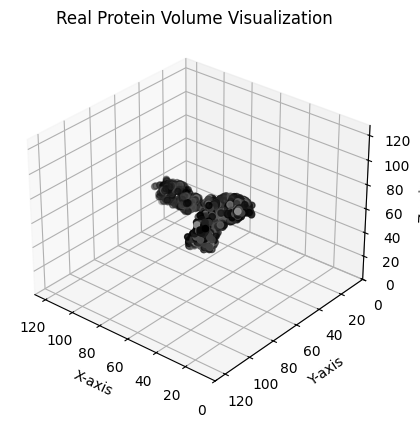

In [ ]:
mrc_file_path = "/path/to/your/directory/data/vols/000.mrc"

with mrcfile.open(mrc_file_path, permissive=True) as mrc:
    protein_raw = mrc.data
    visualize_3D(128, protein_raw, 0.3, 130, "Real Protein Volume Visualization")

Visualization of Projections of the Protein in Real Space

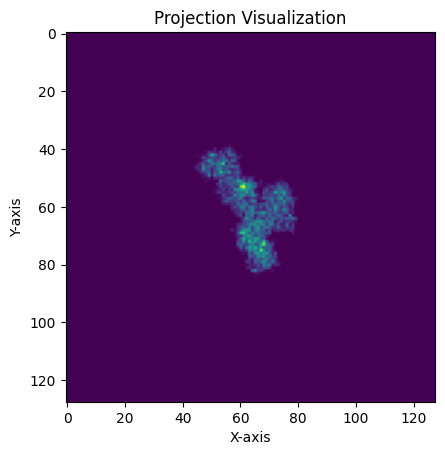

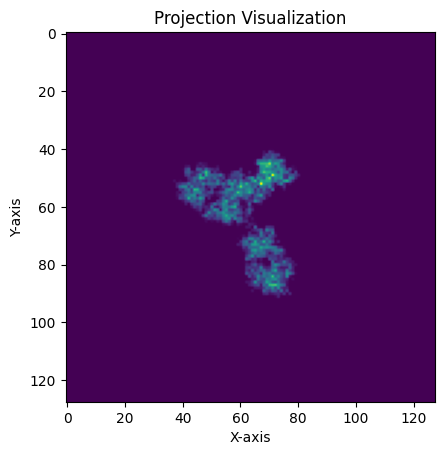

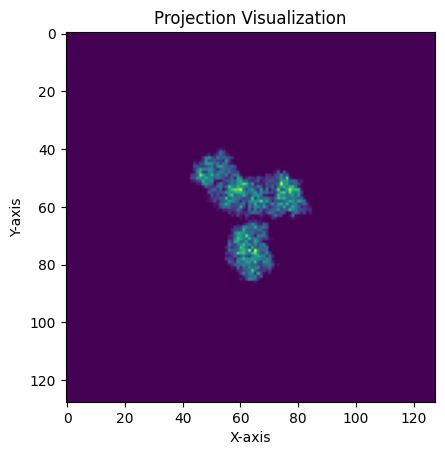

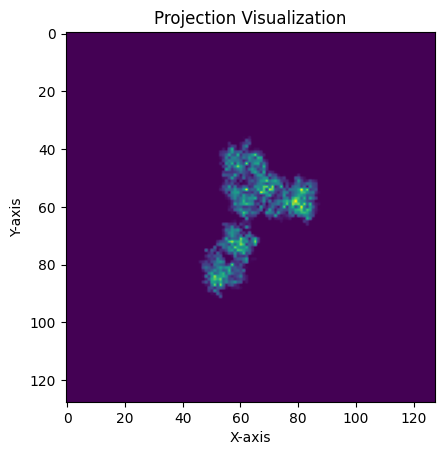

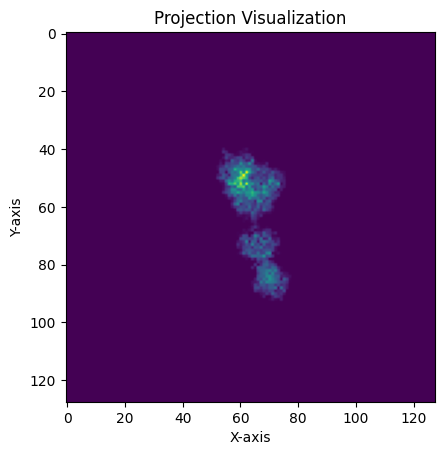

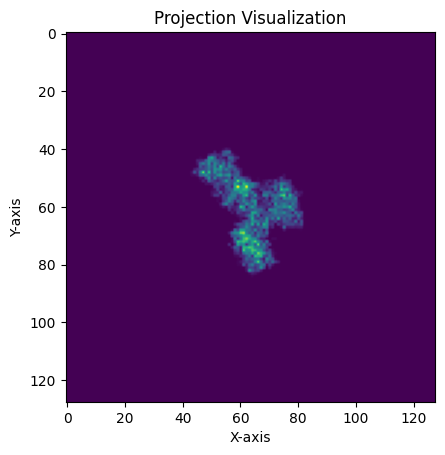

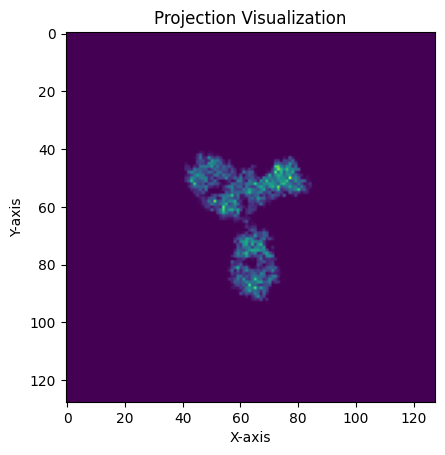

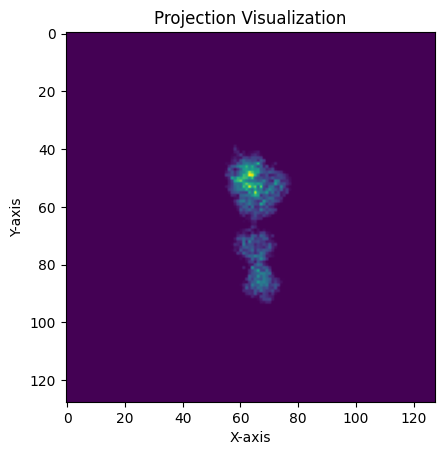

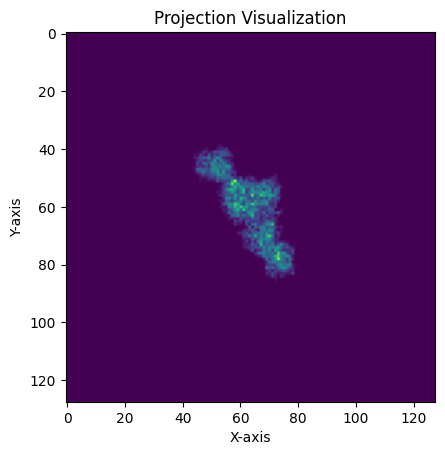

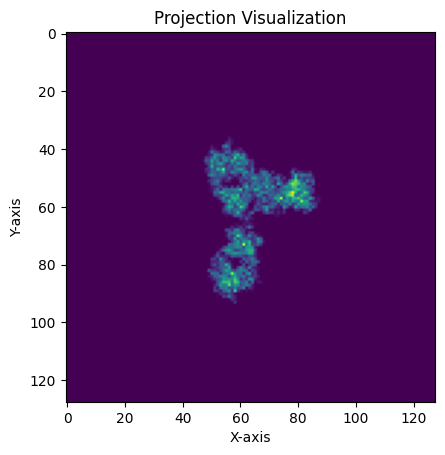

In [ ]:
projections = open('/path/to/your/directory/data/slices_000.pkl', 'rb')
projections = pickle.load(projections)

num_plot = 10 # change as desired

for projection in projections[:num_plot]: 
    data2D = projection
    visualize_2D(data2D, "Projection Visualization")

3D Reconstruction given 2D projections.

Note that in our model we are reconstructing from 2D slices of the Fourier spaced volume. 
This is just a preliminary demonstration that it is possible. 
This demonstration is valid since by the Fourier Slice Theorem the Fourier transform of 2D projections is equivalent to the slice of the corresponding 3D volume in Fourier space. 

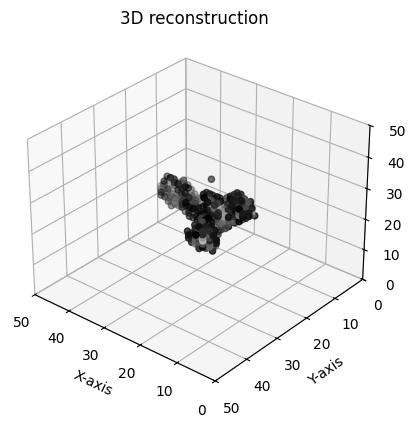

In [ ]:
projections = open('/path/to/your/directory/data/slices_000.pkl', 'rb')
rotations = open('/path/to/your/directory/data/rotations_000.pkl', 'rb')

projections = pickle.load(projections)
rotations = pickle.load(rotations)

images_fourier = []
used_rotations = []

slices = []

num_slices = 10
skip_factor = len(projections) // num_slices
D = 50

for projection, pose in zip(projections[::skip_factor], rotations[::skip_factor]): 
    data2D = projection
    data2D = cv2.resize(projection, (D, D), interpolation=cv2.INTER_CUBIC)
    slices.append(data2D)
    used_rotations.append(pose)

fvol = get_volume(50, used_rotations, slices, False)
visualize_3D(50, ifft(fvol), 0.3, 130, "3D reconstruction")

Fourier Slice Theorem Proof
By comparing Fourier spaced 2D projections to 2D slices taken out of the 3D Fourier spaced volume, we see that they are equivalent, effectively proving the Fourier Slice Theorem. 

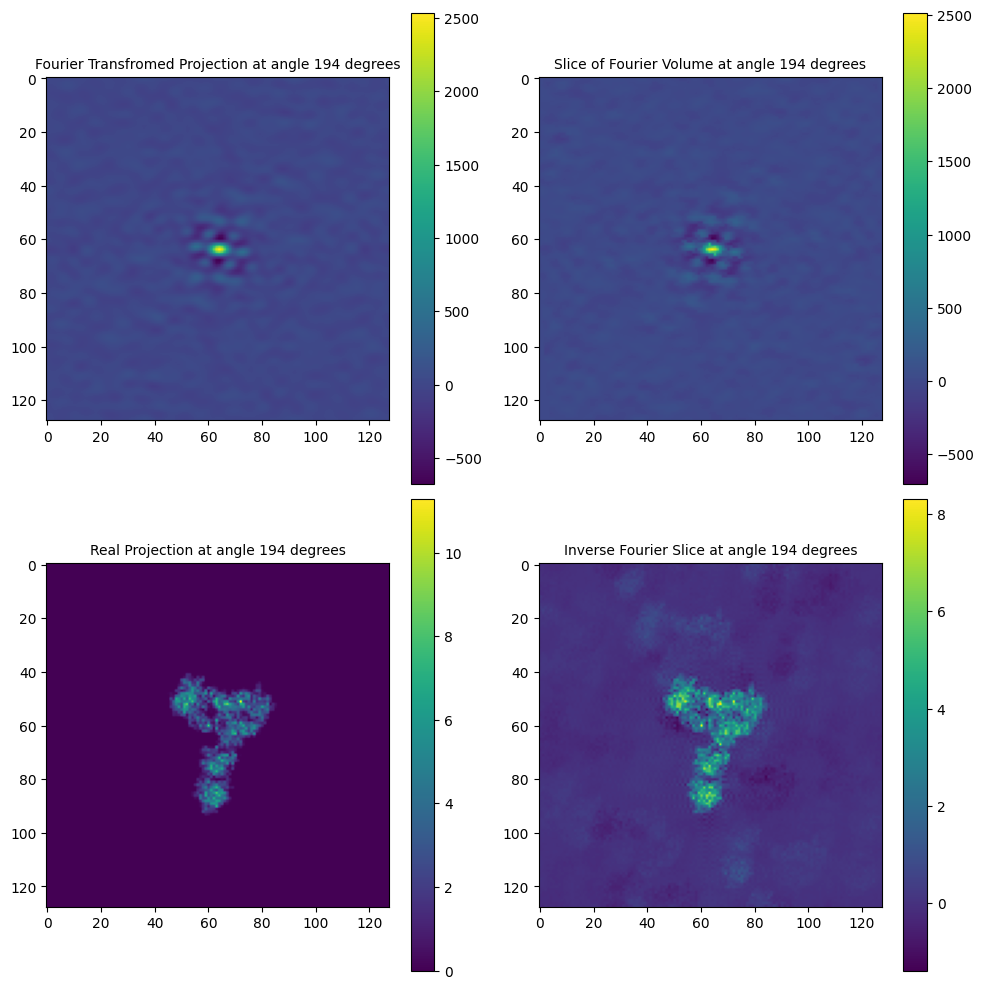

In [9]:
thetas = np.linspace(0, 360, num=100, endpoint=False, dtype=int)
np.random.shuffle(thetas)
slices = []
projections = []
rotation_matrices = []
D = 128

fprotein = fft(protein_raw)

for theta in thetas:
    random_axis = generate_rand_axis(3)
    R = get_rotation_matrix(theta, random_axis)
    rotation_matrices.append(R)

    f_rotated_protein = rotate_arbitrary_axis(fprotein, R, order=0)
    fourier_slice = f_rotated_protein[:, :, D // 2]
    slices.append(fourier_slice)

    projection = rotate_arbitrary_axis(protein_raw, R, order=0).sum(axis = 2)
    projections.append(projection)


num_rows = 2 
num_cols = 2 
num_plot = 1  # Number of iterations to plot (change as needed)

for i in range(num_plot):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))  # Adjust figsize for clarity
    
    # First plot: Fourier-transformed projection
    ax1 = axes[0, 0]
    im1 = ax1.imshow(np.fft.fftshift(np.fft.fftn(np.fft.fftshift(projections[i]))).real)
    ax1.set_title(f"Fourier Transfromed Projection at angle {thetas[i]} degrees", fontsize=10)
    plt.colorbar(im1, ax=ax1)

    # Second plot: Slice in Fourier Space
    ax2 = axes[0, 1]
    im2 = ax2.imshow(slices[i].real)
    ax2.set_title(f"Slice of Fourier Volume at angle {thetas[i]} degrees", fontsize=10)
    plt.colorbar(im2, ax=ax2)

    # Third plot: Real projection
    ax3 = axes[1, 0]
    im3 = ax3.imshow(projections[i].real)
    ax3.set_title(f"Real Projection at angle {thetas[i]} degrees", fontsize=10)
    plt.colorbar(im3, ax=ax3)

    # Fourth plot: Inverse Fourier-transformed slice
    ax4 = axes[1, 1]
    im4 = ax4.imshow(np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(slices[i]))).real)
    ax4.set_title(f"Inverse Fourier Slice at angle {thetas[i]} degrees", fontsize=10)
    plt.colorbar(im4, ax=ax4)

    plt.tight_layout()
    plt.show()
    